###**0. Imports e connect à Google Drive**

In [1]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
import re
from PIL import Image  #Python Imaging Library
import cv2
import copy
import zipfile
import gdown
import albumentations as A
import random
import datetime
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint, TensorBoard
from keras.optimizers import Adam  # usar isto qnd puder para alterar a learning rate
from sklearn import metrics

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# este comando é usado para mudar a diretória atual para o dataset
%cd /content/drive/MyDrive/Mars_Capstone_Project/MarsSampleLocalization_Dataset

/content/drive/MyDrive/Mars_Capstone_Project/MarsSampleLocalization_Dataset


##**Primeiro passo:** Extrair os ficheiros .png para entrarem no modelo, i.e., criar X_train e X_val

In [8]:
def number_of_images(X_type):

    root = './organized_data_gray/' + X_type + '/X_' + X_type + '_detection'
    files = os.listdir(root)

    return len(files)

In [9]:
number_of_images('train'), number_of_images('valid')

(1872, 132)

In [10]:
# acessar às imagens e bboxes guardadas na drive, criadas a partir de outro código
# normalizando-as

def create_X_set_normalized(X_type):

    X_set = []
    root = './organized_data_gray/' + X_type + '/X_' + X_type + '_detection'
    length = number_of_images(X_type)

    for i in range(0, length):

      try:
        path = root + '/processed_' + X_type + 'image_' + str(i) + '.png'
        arr3 = cv2.imread(path)
        img_arr, _, _ = cv2.split(arr3)
        img_normalized = cv2.normalize(img_arr, None, -1, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        img_resized = cv2.resize(img_normalized,(512,360))

        X_set.append(img_resized)

      except ValueError:
        pass

    return np.array(X_set)

In [11]:
X_train = create_X_set_normalized('train')
X_val = create_X_set_normalized('valid')

In [12]:
X_train.shape, X_val.shape

((1872, 360, 512), (132, 360, 512))

##**Segundo passo:** Extrair as coordenadas das bounding boxes diretamente dos ficheiros csv, i.e., criar y_train e y_val

In [13]:
df_ytrain = pd.read_csv('./organized_data_gray/train/y_train_detection.csv')
df_yval = pd.read_csv('./organized_data_gray/valid/y_val_detection.csv')

In [14]:
def y_set(df):

  y = []

  for i in range(df.shape[0]):
      vector = []

      for j in range(df.shape[1]):
          vector.append(df.iloc[i,j])

      y.append(vector)

  return np.array(y)

In [15]:
y_train_detection = y_set(df_ytrain)
y_val_detection = y_set(df_yval)

y_train_detection[:2], y_val_detection[:2]  # estes estão organizados devidamente, mas o X_train e X_val não estão

(array([[0.55348608, 0.67904656, 0.07315046, 0.0631929 ],
        [0.77792498, 0.5537694 , 0.13965087, 0.13414634]]),
 array([[0.70560578, 0.91962306, 0.08977556, 0.08536585],
        [0.95207294, 0.3248337 , 0.02743142, 0.03547672]]))

In [16]:
y_train_detection.shape, y_val_detection.shape

((1872, 4), (132, 4))

In [17]:
def prepare_y_set_detection(y_set):

    y = []
    for bbox in y_set:

        if np.isnan(bbox[0]):
          y.append([1,0])  # [1,0] representa 0, ou seja, o tubo não está presente

        else:
          y.append([0,1])

    return np.array(y)

In [18]:
y_train = prepare_y_set_detection(y_train_detection)
y_val = prepare_y_set_detection(y_val_detection)

print(y_train.shape, y_val.shape)

(1872, 2) (132, 2)


--- **Apenas a verificar se está a acertar na presença do tubo** ---

In [19]:
# esta função também pode servir para mostrar uma imagem sem bounding box, basta colocar bbox = []

def show_image_bbox(X_arr, y_arr, new_img_path):

  y_arr_albu = [0,0,0,0]

  if len(y_arr) != 0:
    y_arr_albu[0] = y_arr[0] - y_arr[2] / 2
    y_arr_albu[1] = y_arr[1] - y_arr[3] / 2
    y_arr_albu[2] = y_arr[2] + y_arr_albu[0]
    y_arr_albu[3] = y_arr[3] + y_arr_albu[1]


  # os valores da bbox têm de entrar normalizados
  shape_after = X_arr.shape

  X_arr = cv2.merge([X_arr, X_arr, X_arr])   # para conseguir visualizar uma imagem a cinzento

  bbox_ = copy.deepcopy(y_arr_albu)
  pil_img = tf.keras.utils.array_to_img(X_arr)  # esta função tira a normalização do array (não tem muito problema dado que esta função é apenas para demonstração, no modelo entram os valores normalizados)

  tf.keras.utils.save_img(new_img_path, pil_img)

  if len(bbox_) != 0:
    bbox_[0] *= shape_after[1]
    bbox_[1] *= shape_after[0]
    bbox_[2] *= shape_after[1]
    bbox_[3] *= shape_after[0]

    start_point = (int(bbox_[0]), int(bbox_[1]))
    end_point = (int(bbox_[2]), int(bbox_[3]))

  color = (255,0,0)  # RGB, fica vermelho desta forma
  thickness = 1

  image = cv2.imread('./' + new_img_path)

  if len(bbox_) != 0:
    image = cv2.rectangle(image, start_point, end_point, color, thickness)  # tem de se usar valores inteiros aqui
    image = cv2.putText(image, 'sample', (int(bbox_[0]), int(bbox_[1] - 3)), 0, 0.3, (255,0,0), 1)

  final_img = tf.keras.utils.array_to_img(image)

  return final_img

The sample is not in the image


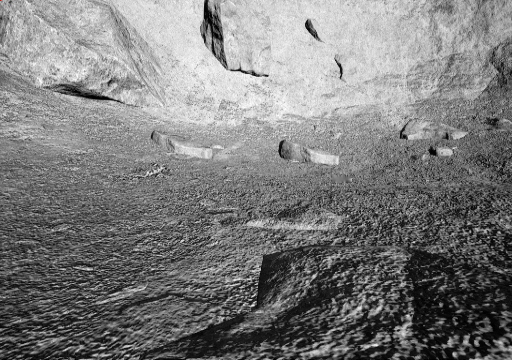

In [20]:
index = 1000

if list(y_train[index]) == [0,1]:
  print('The sample is in the image')
else:
  print('The sample is not in the image')

show_image_bbox(X_train[index], [], 'detection.png')

##**Terceiro passo:** Obter uma imagem aleatoria de X_test e y_test

In [17]:
len(os.listdir('./organized_data_gray/test/X_test_images'))

2884

In [18]:
# esta função vai apenas buscar uma imagem de cada vez ao conjunto de teste,
# porque não dava para guardar 3000 imagens numa variável e correr
# o modelo sem problemas com a RAM

def choose_or_randomize_testimage(choice):

    length = len(os.listdir('./organized_data_gray/test/X_test_images'))
    root = './organized_data_gray/test/X_test_images'

    if choice == 'random':
      number = random.choice(list(range(0, length)))

    else:
      number = choice

    # buscar a imagem
    path = root + '/processed_testimage_' + str(number) + '.png'
    arr3 = cv2.imread(path)
    img_arr, _, _ = cv2.split(arr3)
    img_normalized = cv2.normalize(img_arr, None, -1, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    # buscar a bounding box
    df_ytest = pd.read_csv('./organized_data_gray/test/y_test.csv')
    y = []

    for j in range(0, df_ytest.shape[1]):
      y.append(df_ytest.iloc[number, j])

    X_testimage = np.array(img_normalized)
    y_testbbox = np.array(y)

    return X_testimage, y_testbbox

In [19]:
choice = 'random'
test_image, ground_truth_bbox = choose_or_randomize_testimage(choice)

try:
  show_image_bbox(test_image, ground_truth_bbox, 'imagetest.png')
  print('There is a sample in this image')
except ValueError:
  print('There is no sample in this image')

##**Quarto passo:** Callbacks: ModelCheckpoint, CSVLogger, TensorBoard

In [21]:
!mkdir callbacks
!mkdir ./callbacks/tensorboard
!mkdir ./callbacks/checkpoints

mkdir: cannot create directory ‘callbacks’: File exists
mkdir: cannot create directory ‘./callbacks/tensorboard’: File exists
mkdir: cannot create directory ‘./callbacks/checkpoints’: File exists


In [22]:
# preparar o CSVLogger callback object

logger_path = './callbacks/graytraining_logger' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S') + '.log'  # tem gray na path do file para diferenciar
csv_logger = CSVLogger(logger_path,
                       append=True,
                       separator=',')

In [23]:
# preparar o ModelCheckpoint callback object

checkpoint_path = './callbacks/checkpoints/grayCkpt1_{epoch:02d}_{val_loss:.05f}_.h5'
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min',
                             verbose=1)

In [24]:
# preparar o TensorBoard callback object

%load_ext tensorboard

tboard_path = './callbacks/tensorboard/gray_' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard = TensorBoard(log_dir = tboard_path,
                          histogram_freq=1)

## **Quinto passo**: Construir o modelo

###**Arquitetura do modelo**

In [21]:
X_train.shape

(1872, 360, 512)

In [22]:
_, height, width = X_train.shape

model = Sequential([

    Conv2D(filters=64, kernel_size=(3,3), input_shape=(360, 512, 1), activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2, 2), padding="valid"),
    Dropout(0.1),

    Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2, 2), padding="valid"),
    Dropout(0.1),

    Conv2D(filters=16, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2, 2), padding="valid"),
    Dropout(0.1),

    Flatten(),
    Dense(128, activation='relu'),

    Dense(2, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 358, 510, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 179, 255, 64)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 179, 255, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 177, 253, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 88, 126, 32)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 88, 126, 32)       0

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss= 'binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train,
          y_train,
          epochs = 30,
          batch_size = 15,
          validation_data = (X_val, y_val),
          callbacks = [checkpoint, csv_logger, tensorboard])

In [24]:
model.load_weights('./callbacks/checkpoints/grayCkpt1_13_0.68606_ .h5')

###**Predictions**

In [25]:
# predictions with X_val
y_pred = model.predict(X_val)
y_pred[:5]

5/5 [==============================] - 17s 3s/step


array([[1.14860256e-07, 9.99999821e-01],
       [9.55254257e-01, 4.47457172e-02],
       [7.55105093e-02, 9.24489498e-01],
       [1.50127971e-06, 9.99998391e-01],
       [1.66385348e-07, 9.99999821e-01]], dtype=float32)

In [ ]:
%tensorboard --logdir=./callbacks/tensorboard

In [26]:
# esta função fornece um entendimento direto do conjunto y em causa:
# se o elemento é 0, não há sample na imagem
# se o elemento é 1, a sample está na imagem

def zeros_and_ones(y_set):

    y_zeros_ones = []
    for y in y_set:

      confidence = round(y[1], 1)

      if confidence < 0.5:
        y_zeros_ones.append(0)

      else:
        y_zeros_ones.append(1)

    return np.array(y_zeros_ones)

In [59]:
y_pred_01 = zeros_and_ones(y_pred)
y_val_01 = zeros_and_ones(y_val)

y_val_01[:5], y_pred_01[:5]

(array([1, 1, 1, 1, 1]), array([1, 0, 1, 1, 1]))

The sample is in the image


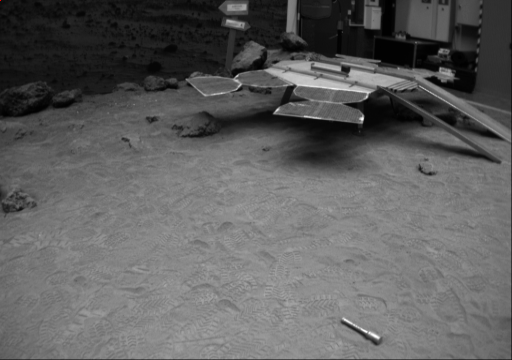

In [35]:
index = 0

if y_pred_01[index] == 1:
  print('The sample is in the image')
else:
  print('The sample is not in the image')

show_image_bbox(X_val[index], [], 'detection.png')

###**Métricas**: Confusion Matrix, Precision, Recall e F1 Score

In [73]:
def precision_recall_f1_cm(conf_threshold):

    indexes_positives = []
    y_pred_01_new = copy.deepcopy(y_pred_01)

    for i, y in enumerate(y_pred):

        confidence = round(y[1], 3)

        if confidence >= conf_threshold:
          y_pred_01_new[i] = 1
          indexes_positives.append(i)

        else:
          y_pred_01_new[i] = 0

    cm = metrics.confusion_matrix(y_val_01, y_pred_01_new)
    TN, FP, FN, TP = cm.ravel()

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = TP / (TP + 0.5 * (FP + FN))

    lst = [conf_threshold, precision, recall, f1_score]

    return lst, cm, indexes_positives

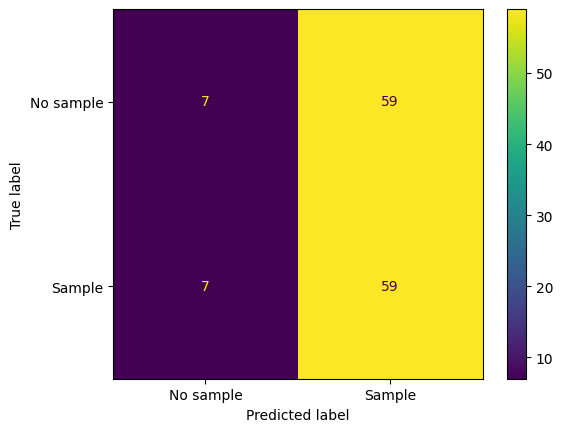


precision = 0.5 
recall = 0.894 
f1-score = 0.641


In [109]:
# dar plot na Confusion Matrix
conf = 0.1
cm = precision_recall_f1_cm(conf)[1]
cm_plt = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,
                                        display_labels = ['No sample', 'Sample'])
cm_plt.plot()
plt.show()

precision = precision_recall_f1_cm(conf)[0][1]
recall = precision_recall_f1_cm(conf)[0][2]
f1_score = precision_recall_f1_cm(conf)[0][3]

print('\nprecision =', round(precision, 3),
      '\nrecall =', round(recall, 3),
      '\nf1-score =', round(f1_score, 3))

In [133]:
conf_thresholds = [round(i * 0.1, 1) for i in range(0,11)]
cols = [ 'confidence_threshold', 'precision', 'recall', 'f1-score']
conf_rows = [precision_recall_f1_cm(conf)[0] for conf in conf_thresholds]

In [134]:
df = pd.DataFrame(conf_rows, columns = cols)
df.set_index('confidence_threshold', inplace=True)
df

,precision,recall,f1-score
confidence_threshold,,,
0.0,0.500000,1.000000,0.666667
0.1,0.500000,0.893939,0.641304
0.2,0.500000,0.833333,0.625000
0.3,0.500000,0.787879,0.611765
0.4,0.500000,0.727273,0.592593
0.5,0.500000,0.681818,0.576923
0.6,0.505747,0.666667,0.575163
0.7,0.500000,0.651515,0.565789
0.8,0.500000,0.651515,0.565789


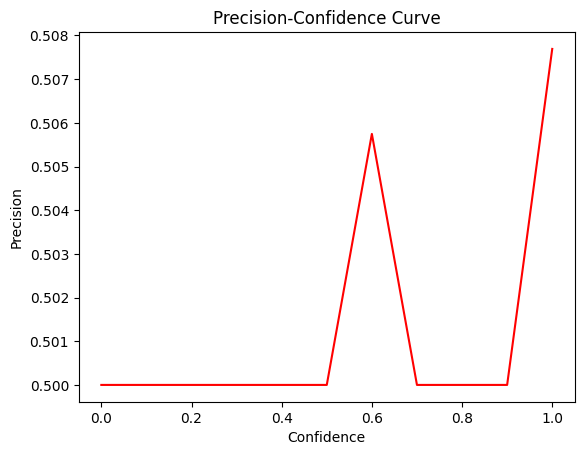

In [138]:
# fazer plot de Precision-Confidence curve
x = df.index
y = df['precision'].to_list()

plt.plot(x, y, color='red')
plt.xlabel('Confidence')
plt.ylabel('Precision')
plt.title('Precision-Confidence Curve')
plt.show()

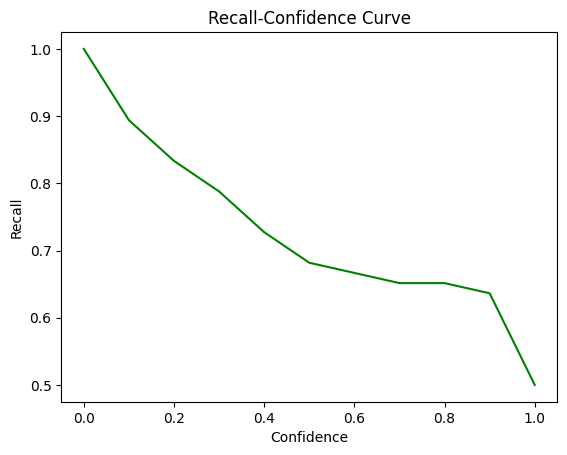

In [139]:
# fazer plot de Recall-Confidence curve
x = df.index
y = df['recall'].to_list()

plt.plot(x, y, color='green')
plt.xlabel('Confidence')
plt.ylabel('Recall')
plt.title('Recall-Confidence Curve')
plt.show()

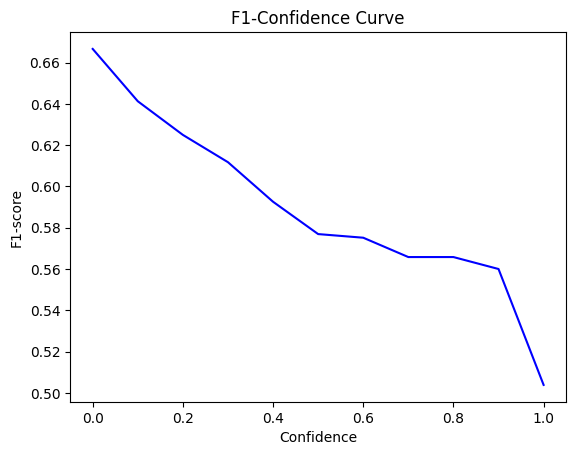

In [141]:
# fazer plot de F1-Confidence curve
x = df.index
y = df['f1-score'].to_list()

plt.plot(x, y, color='blue')
plt.xlabel('Confidence')
plt.ylabel('F1-score')
plt.title('F1-Confidence Curve')
plt.show()